In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange
from flygym import Simulation, Camera
from flygym.arena import FlatTerrain

In this example, we will simulate a fly chasing another fly based on vision. This is similar to the [visual taxis task in week 4](https://github.com/NeLy-EPFL/cobar-exercises/blob/main/week4/1_vision.ipynb), but the ball will be replaced by a walking fly.

For multi-fly simulation, we might want to control the flies differently and have different observation/action spaces for different flies. Therefore, we will inherit from `Fly` and implement different logic in the `pre_step` method. 

In [9]:
from hybrid_turning_fly import HybridTurningFly
from movodor_arena import MovOdorArena
from odor_turning_fly import OdorTaxisFly


In [11]:
# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[0, 0, 10],[1, 1, 10]], dtype=np.float32)

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[0.5, 0],[1, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

# Gains for the two odors (negative = attractive, positive = aversive)
odor_gains = np.array([-500, 80])

In [12]:
timestep = 1e-4
decision_interval = 0.05
run_time = 3

fly0 = OdorTaxisFly(  # This is the "chasing" fly (aka male fly)
    name="0",
    odor_threshold = 0.5,
    odor_dimensions=odor_dimensions,
    odor_gains=odor_gains,
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(0, 0, 0),
)


fly1 = HybridTurningFly(  # This is the "chased" fly (aka female fly)
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)


arena = MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    num_sensors=4,
    move_speed=0,
    move_direction="right",
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

# THIS IS THE CAMERA THAT WILL BE USED FOR FOLLOWING THE CENTER OF MASS OF THE FLY
mov_birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="mov_birdeye_cam",
    mode="fixed",
    pos=(15, 0, 40), # (15, 0, 40) the 40 is the camera height which is constant
    euler=(0, 0, 0),
    fovy=45,
)
#-------------------------------------------------------------------------------

cam = Camera(
    fly=fly0,
    camera_id="Animat/camera_left", # This is not used as argument
    play_speed=0.5,
    window_size=(800, 608),
)


sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

### Construction of controlling signals and P1

In [13]:
def p1_control_signal(run_time: float, time_step: float) -> np.ndarray:
    """Returns a P1 signal [0,1].
    The control signal is a 2D array of shape (num_time_steps, 2)"""
    
    # P1 signal is a 2D array of shape (num_time_steps, 2)
    p1_signal = np.ones((int(run_time / time_step), 1))
    
    # Create a sine wave signal 
    p1_signal[:, 0] = 0.5*(np.sin(2 * np.pi * np.linspace(0, run_time, int(run_time / time_step)))+1)
    
    
    return p1_signal

def plot_signal(p1_signal, name: str):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
    ax.plot(p1_signal)
    ax.set_xlabel("Time steps")
    ax.set_ylabel(name)
    ax.set_title(name)

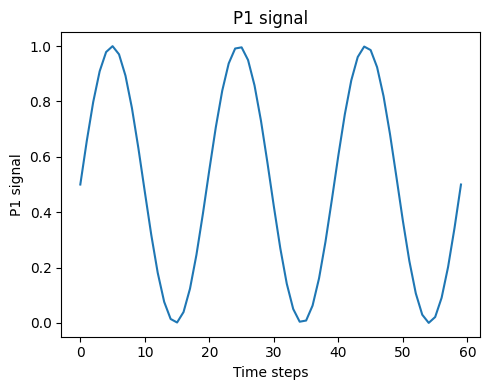

In [14]:
p1_signal = p1_control_signal(run_time, decision_interval)
plot_signal(p1_signal, "P1 signal")

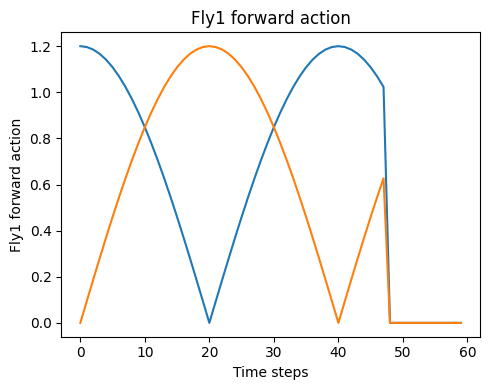

In [16]:
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / timestep)

t = np.arange(0, run_time, decision_interval)

fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

# set the last 20% of the actions to 0
fly1_actions[int(0.8 * num_decision_steps) :, :] = 0

plot_signal(fly1_actions, "Fly1 forward action")

#### Run the simulation

In [19]:
# Changes the color of the fly to black
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# For the camera following the fly
second_cam_frames = []
x = None
y = None
alpha = 1e-1

# Initialize the control signal
control_signal = np.zeros(odor_dimensions)
obs_history = []
odor_source_hist = []

obs, _ = sim.reset(seed=seed)
for i in trange(num_decision_steps):
    control_signal = fly0.process_odor_intensities(obs["0"]["odor_intensity"])
    control_signal *= p1_signal[i]
    
    for j in trange(physics_steps_per_decision_step):
        obs, _, _, _, info = sim.step(
        {
            "0": control_signal,
            "1": fly1_actions[i],
        }
        )
            
        #To bind the odor source position to a fly position
        for j in range(len(arena.odor_source)):
            arena.odor_source[j] = obs[str(j)]["fly"][0]
            arena.odor_source[j][2] = 4    #add an offset to the odor source position on z axis

        #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY ------------------------------------------------
        render_res = sim.render()[0]

        if render_res is not None:
            second_cam = sim.physics.bind(mov_birdeye_cam)

            x_new = obs["0"]["fly"][0][0]
            y_new = obs["0"]["fly"][0][1]

            if x is None:
                x = x_new
            
            if y is None:
                y = y_new

            x = (1 - alpha) * x + alpha * x_new
            y = (1 - alpha) * y + alpha * y_new

            second_cam.pos[0] = x
            second_cam.pos[1] = y

            second_img = sim.physics.render(
                width=700, height=560, camera_id="mov_birdeye_cam"
            )
            second_img = cv2.putText(
                np.ascontiguousarray(second_img),
                f"{sim.cameras[0].play_speed}x",
                org=(20, 30),
                fontFace=cv2.FONT_HERSHEY_DUPLEX,
                fontScale=0.8,
                color=(0, 0, 0),
                lineType=cv2.LINE_AA,
                thickness=1,
            )
            second_cam_frames.append(second_img)
            #------------------------------------------------------------------------------------------------

        odor_source_hist.append(arena.odor_source.copy())
        obs_history.append(obs)

 33%|███▎      | 20/60 [06:23<12:47, 19.20s/it]


KeyboardInterrupt: 

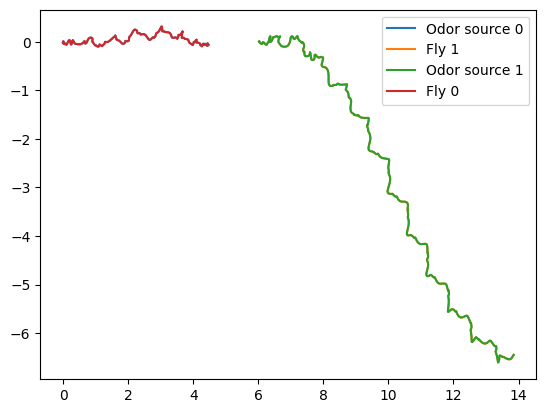

In [20]:
# plot the odor source trajectory vs fly trajectory
import matplotlib.pyplot as plt
fly_pos_hist_1 = np.array([obs["1"]["fly"][0, :2] for obs in obs_history])
fly_pos_hist_0 = np.array([obs["0"]["fly"][0, :2] for obs in obs_history])
odor_source_hist = np.array(odor_source_hist)
plt.plot(odor_source_hist[:,0,0], odor_source_hist[:,0,1], label="Odor source 0")
plt.plot(fly_pos_hist_1[:,0], fly_pos_hist_1[:,1], label="Fly 1")
plt.plot(odor_source_hist[:,1,0], odor_source_hist[:,1,1], label="Odor source 1")
plt.plot(fly_pos_hist_0[:,0], fly_pos_hist_0[:,1], label="Fly 0")
plt.legend()
plt.show()

In [21]:
#birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
cam.save_video("video_chasing/chasing_with_odor5.mp4")

In [22]:
from IPython.display import Video

Video("video_chasing/chasing_with_odor5.mp4", width=800, height=608)